<a href="https://colab.research.google.com/github/Kasimer-0/CSCI218_Group-FT32/blob/main/CNN_(ResNet_50_Transfer_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 🔧 Setup & Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from google.colab import drive
drive.mount('/content/drive')
model.eval() # Switch to evaluation mode
print("Model is ready for evaluation.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model is ready for evaluation.


In [ ]:
# ===========================================
# 1. Experimental Setup and Data Preparation
# ===========================================

# Set a random seed
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define image preprocessing (must be consistent with the input required by the pre-trained model)
# ResNet expects a 224x224 input, and it is normalized in a specific way
transform = transforms.Compose([
  transforms.Resize(256),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  # Standard mean and variance of ImageNet (ResNet is trained on this data distribution)
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset path (please modify to your own path)
data_dir = '/content/drive/MyDrive/CSCI218/Dog dataset/Images'

# Load the dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names[:5]}...")

# Split the training and validation sets (80% / 20%)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Using device: cuda
Detected 50 classes: ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu']...


In [ ]:
# ===========================================
# 2. Loading the Pre-trained ResNet Model (Transfer Learning Core)
# ==========================================
print("Loading the pre-trained ResNet-50 model...")

# Loading the pre-trained weights on ImageNet (weights='DEFAULT' automatically selects the best weights)
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# [Key Step 1] Freeze Model Parameters
# We don't want to break the pre-trained "visual ability," so we lock the previous layers and don't update their weights.
for param in model.parameters():
  param.requires_grad = False

# [Key Step 2] Modify the fully connected layer (Replace the Head)
# The last layer of ResNet50 is called 'fc', with 2048 input features
num_ftrs = model.fc.in_features

# Replace it with a new linear layer, with the number of output nodes equal to the number of dog breeds (50)
# The newly created layer requires_grad=True by default, so it will be trained
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# ===========================================
# 3. Define the loss function and optimizer
# ===========================================
criterion = nn.CrossEntropyLoss()

# [Key Step 3] Optimize only the parameters of the last layer
# This makes training extremely fast because it eliminates the need to calculate gradients for the first few hundred layers.
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

Loading the pre-trained ResNet-50 model...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 180MB/s]


In [ ]:
# ===========================================
# 4. Training Loop
# ============================================
num_epochs = 10 # Transfer learning usually converges with very few epochs
print("Start training ResNet-50 (Transfer Learning)...")

train_acc_history = []
val_acc_history = []
train_loss_history = [] # Record training loss

for epoch in range(num_epochs):
  # --- Training Phase ---
  model.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(train_loader)
  epoch_acc = correct_train / total_train
  train_acc_history.append(epoch_acc)
  train_loss_history.append(epoch_loss) # Record training loss

  # --- Verification Phase ---
  model.eval()
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total_val += labels.size(0)
      correct_val += (predicted == labels).sum().item()

  val_acc = correct_val / total_val
  val_acc_history.append(val_acc)

  print(f"Epoch [{epoch+1}/{num_epochs}] "
      f"Loss: {epoch_loss:.4f} | "
      f"Train Acc: {epoch_acc:.4f} | "
      f"Val Acc: {val_acc:.4f}")

print("Training complete!")
# Save the model
torch.save(model.state_dict(), 'resnet50_transfer_learning.pth')

Start training ResNet-50 (Transfer Learning)...
Epoch [1/10] Loss: 1.7988 | Train Acc: 0.6668 | Val Acc: 0.8368
Epoch [2/10] Loss: 0.5988 | Train Acc: 0.8810 | Val Acc: 0.8731
Epoch [3/10] Loss: 0.3950 | Train Acc: 0.9102 | Val Acc: 0.8765
Epoch [4/10] Loss: 0.2978 | Train Acc: 0.9361 | Val Acc: 0.8839
Epoch [5/10] Loss: 0.2375 | Train Acc: 0.9496 | Val Acc: 0.8805
Epoch [6/10] Loss: 0.1908 | Train Acc: 0.9635 | Val Acc: 0.8720
Epoch [7/10] Loss: 0.1598 | Train Acc: 0.9715 | Val Acc: 0.8754
Epoch [8/10] Loss: 0.1360 | Train Acc: 0.9772 | Val Acc: 0.8742
Epoch [9/10] Loss: 0.1199 | Train Acc: 0.9807 | Val Acc: 0.8827
Epoch [10/10] Loss: 0.1040 | Train Acc: 0.9843 | Val Acc: 0.8748
Training complete!


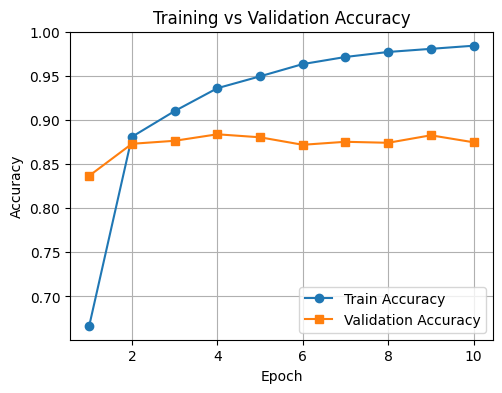

In [ ]:
# ==========================================
# 5. Plotting Training Curves
# ==========================================
plt.figure(figsize=(12, 4))

# Subgraph 1: Training/Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_acc_history, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_acc_history, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

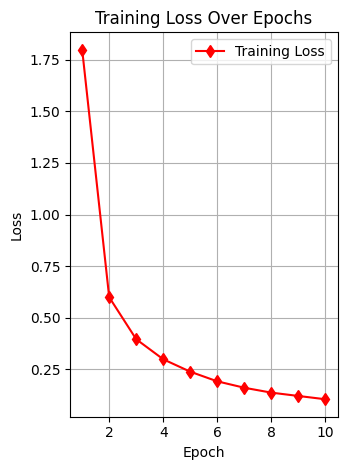

In [ ]:
# Subgraph 2: Training Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_loss_history, label='Training Loss', marker='d', color='red')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("resnet50_training_curves.png") # Save image
plt.show() # Save image

In [ ]:
# ==========================================
# Visualization 1: MODEL SUMMARY
# ==========================================
print("=== Model Summary ===")

# Calculate the number of trainable parameters
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_trainable_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_trainable_params:,}")

# Printable model structure (simplified version)
children = list(model.named_children())
print("\nModel Architecture (First 3 and Last 2 layers):")
for name, module in children[:3]:
    print(f"  ({name}): {module}")
print("  ...")
for name, module in children[-2:]:
    print(f"  ({name}): {module}")

=== Model Summary ===
Total Trainable Parameters: 102,450

Model Architecture (First 3 and Last 2 layers):
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  ...
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=2048, out_features=50, bias=True)


In [ ]:
# ==========================================
# Visualization 2: TEST SET EVALUATION
# ==========================================
print("=== Test Set Evaluation ===")

all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Test Accuracy: {test_accuracy:.4f} ({test_accuracy * 100:.2f}%)")

=== Test Set Evaluation ===
Final Test Accuracy: 0.8748 (87.48%)


=== Generating Confusion Matrix ===


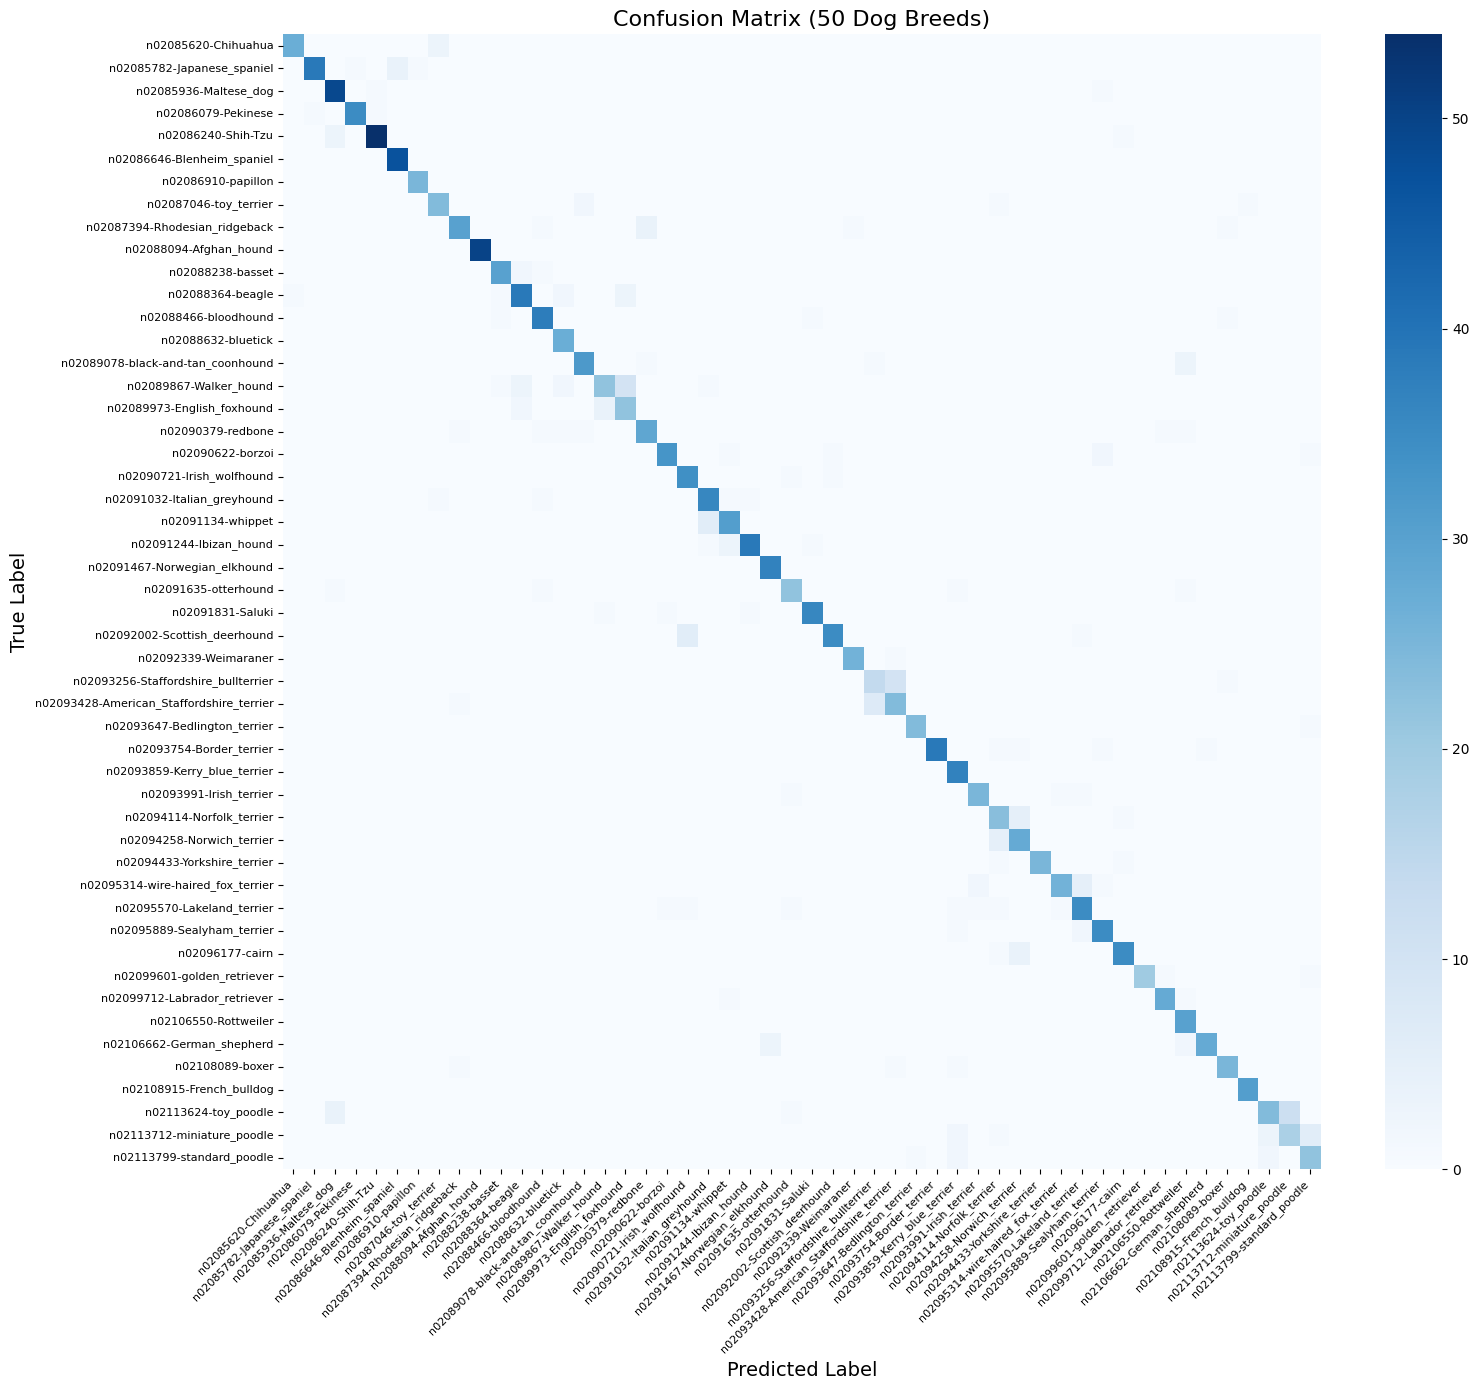

Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
# ==========================================
# Visualization 3: CONFUSION MATRIX
# ==========================================
print("=== Generating Confusion Matrix ===")

class_names = val_dataset.dataset.classes
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (50 Dog Breeds)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=200)
plt.show()

print("Confusion matrix saved as 'confusion_matrix.png'")

=== Visualizing Sample Predictions ===


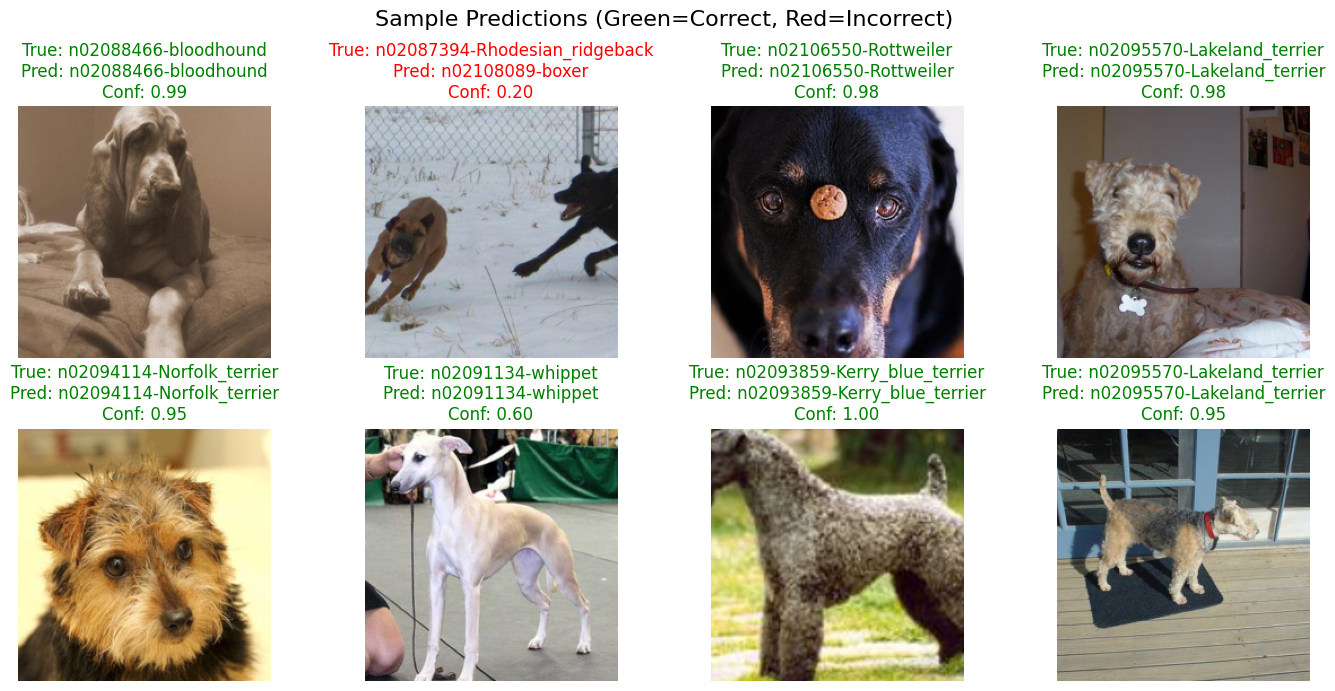

Sample predictions saved as 'sample_predictions.png'


In [ ]:
# ==========================================
# Visualization 4: VISUALIZING CLASSIFICATION RESULTS
# ==========================================
print("=== Visualizing Sample Predictions ===")

# Retrieve a batch of data from the validation set
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
  outputs = model(images)
  probs = F.softmax(outputs, dim=1)
  confidences, preds = torch.max(probs, 1)

# Denormalize the image for proper display
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
  for t, m, s in zip(tensor, mean, std):
      t.mul_(s).add_(m)
  return torch.clamp(tensor, 0, 1)

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
axes = axes.ravel()

for i in range(8):
  img = denormalize(images[i].cpu().clone())
  axes[i].imshow(img.permute(1, 2, 0))
  true_label = class_names[labels[i]]
  pred_label = class_names[preds[i]]
  confidence = confidences[i].item()
  color = 'green' if labels[i] == preds[i] else 'red'
  axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}', color=color)
  axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
plt.tight_layout()
plt.savefig('sample_predictions.png')
plt.show()

print("Sample predictions saved as 'sample_predictions.png'")

In [ ]:
# ==========================================
# Visualization 5: DETAILED CLASSIFICATION REPORT
# ==========================================
print("=== Detailed Classification Report ===")

# Generate a complete classification report
report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Print macro average
macro_avg = report['macro avg']
print(f"Macro Avg - Precision: {macro_avg['precision']:.3f}, "
      f"Recall: {macro_avg['recall']:.3f}, F1-Score: {macro_avg['f1-score']:.3f}")

# Identify the best and worst performing categories
report_df_no_summary = report_df.drop(['accuracy', 'macro avg', 'weighted avg'])
top_5_f1 = report_df_no_summary.nlargest(5, 'f1-score')
bottom_5_f1 = report_df_no_summary.nsmallest(5, 'f1-score')

print("\nTop 5 Best Performing Breeds (by F1-Score):")
print(top_5_f1[['f1-score']])

print("\nTop 5 Worst Performing Breeds (by F1-Score):")
print(bottom_5_f1[['f1-score']])

=== Detailed Classification Report ===
Macro Avg - Precision: 0.874, Recall: 0.872, F1-Score: 0.870

Top 5 Best Performing Breeds (by F1-Score):
                             f1-score
n02088094-Afghan_hound       1.000000
n02108915-French_bulldog     0.984127
n02086910-papillon           0.980392
n02092339-Weimaraner         0.962963
n02094433-Yorkshire_terrier  0.961538

Top 5 Worst Performing Breeds (by F1-Score):
                                     f1-score
n02093256-Staffordshire_bullterrier  0.595745
n02113712-miniature_poodle           0.600000
n02089867-Walker_hound               0.666667
n02113624-toy_poodle                 0.685714
n02089973-English_foxhound           0.698413
